In [1]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU

In [2]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [3]:
DATA_DIR = '../input/massachusetts-roads-dataset/tiff/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [4]:
class_dict = pd.read_csv("../input/massachusetts-roads-dataset/label_class_dict.csv")
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [5]:
select_classes = ['background', 'road']
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values = np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['background', 'road']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [6]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [7]:
class RoadsDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

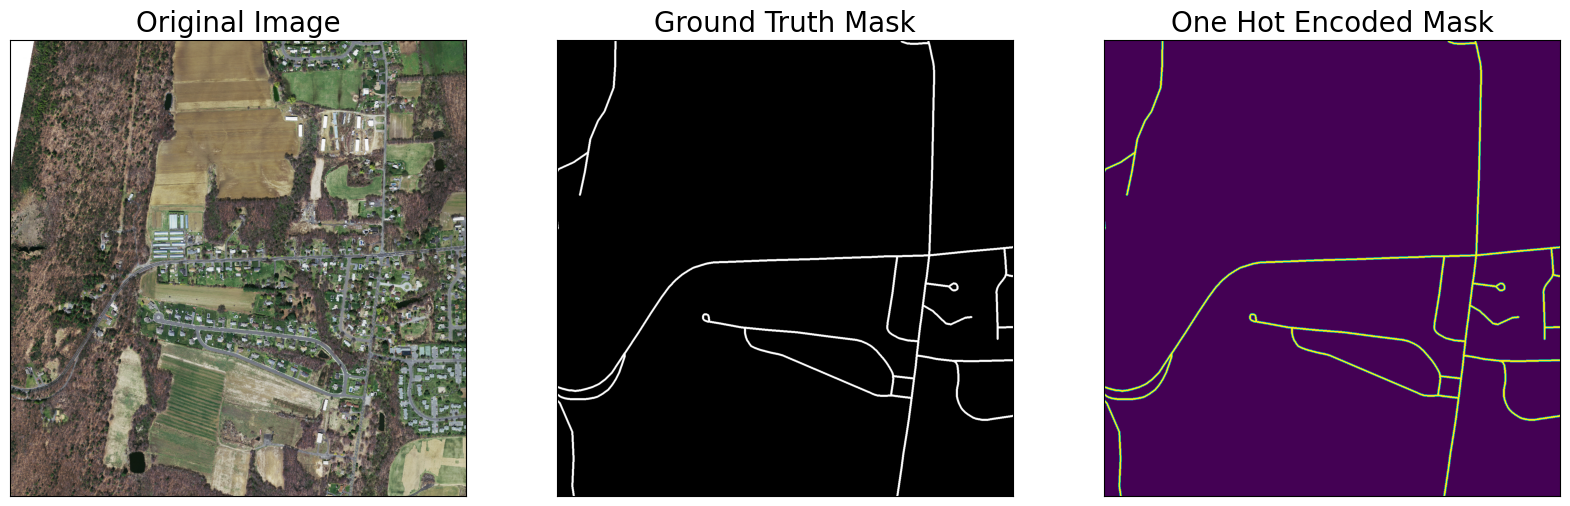

In [8]:
dataset = RoadsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [9]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
        album.OneOf(
            [
                album.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
                album.GridDistortion(p=0.5),
                album.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1),
            ],
            p=0.8,
        ),
        album.OneOf(
            [
                album.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                album.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.5),
                album.RandomGamma(gamma_limit=(80, 120), p=0.5),
            ],
            p=0.8,
        ),
        album.OneOf(
            [
                album.Blur(blur_limit=3, p=0.5),
                album.MedianBlur(blur_limit=3, p=0.5),
                album.MotionBlur(blur_limit=3, p=0.5),
            ],
            p=0.5,
        ),
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):  
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

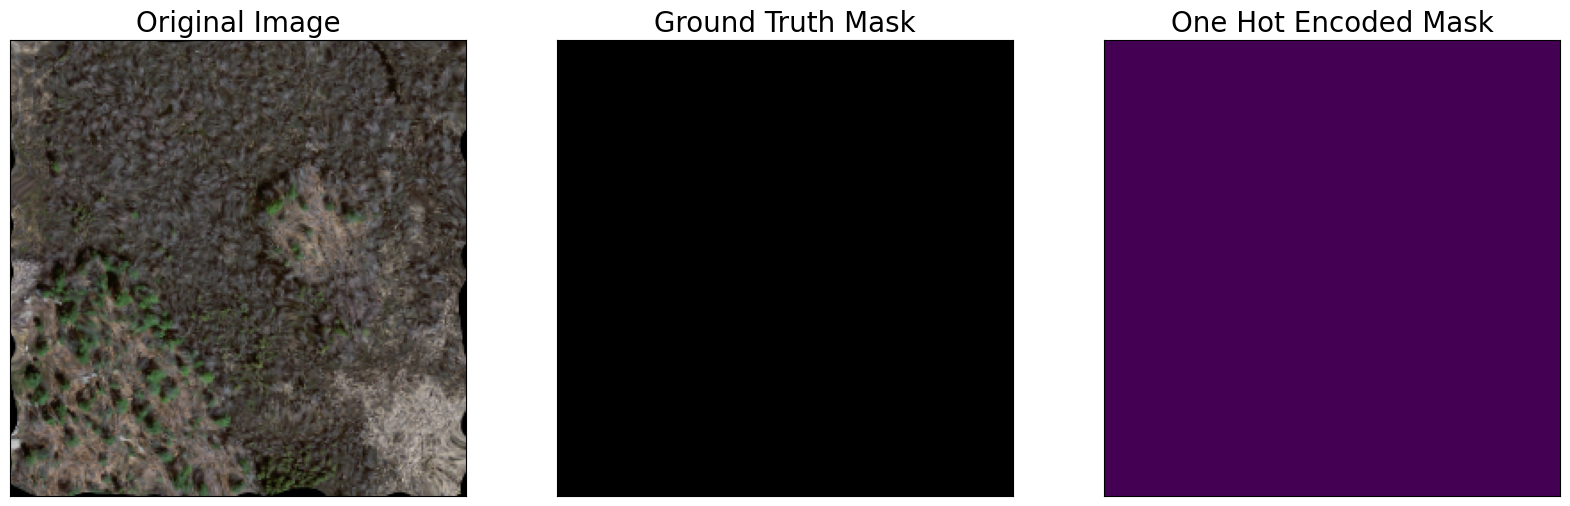

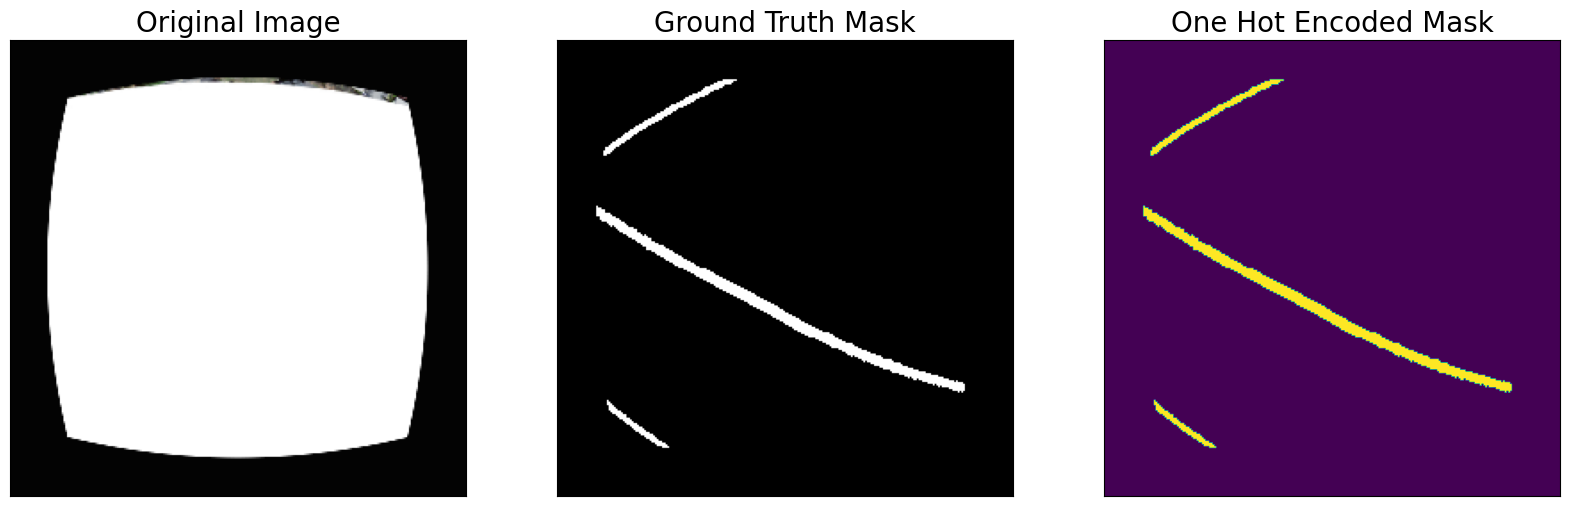

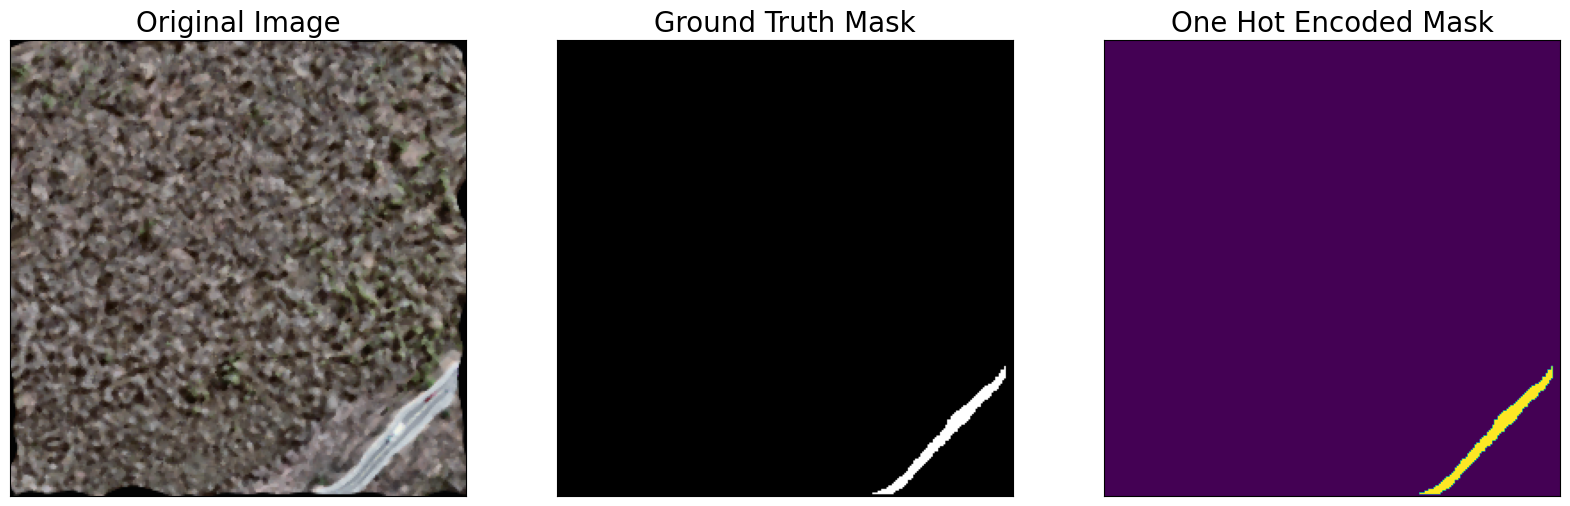

In [10]:
augmented_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

## Training UNet

<h3><center>UNet Model Architecture</center></h3>
<img src="https://miro.medium.com/max/2824/1*f7YOaE4TWubwaFF7Z1fzNw.png" width="750" height="750"/>
<h4><center><a href="https://arxiv.org/abs/1505.04597">Image Courtesy: UNet [Ronneberger et al.]</a></center></h4>

In [11]:
# Model configuration
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid'

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

train_dataset = RoadsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [12]:
# Training configuration
TRAINING = True
EPOCHS = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loss = smp.losses.DiceLoss(mode='binary')
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.00008)])

# Checkpoint setup
CHECKPOINT_DIR = 'checkpoints'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def find_latest_checkpoint():
    checkpoints = list(Path(CHECKPOINT_DIR).glob('epoch_*.pth'))
    if not checkpoints:
        return None
    return str(sorted(checkpoints, key=lambda x: int(x.stem.split('_')[1]))[-1])

RESUME_FROM_CHECKPOINT = None if TRAINING else find_latest_checkpoint()

In [13]:
# Training loop
class NamedDiceLoss(smp.losses.DiceLoss):
    __name__ = 'dice_loss'

# Use this wrapped version instead
loss = NamedDiceLoss(mode='binary')

best_iou_score = 0.0
patience = 10
patience_counter = 0
train_logs, valid_logs = [], []

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch+1}/{EPOCHS}')
    
    train_log = smp.utils.train.TrainEpoch(
        model, loss=loss, metrics=metrics, optimizer=optimizer, device=DEVICE, verbose=True
    ).run(train_loader)
    train_logs.append(train_log)
    
    valid_log = smp.utils.train.ValidEpoch(
        model, loss=loss, metrics=metrics, device=DEVICE, verbose=True
    ).run(valid_loader)
    valid_logs.append(valid_log)
    
    if valid_log['iou_score'] > best_iou_score:
        best_iou_score = valid_log['iou_score']
        patience_counter = 0
        torch.save(model.state_dict(), f'{CHECKPOINT_DIR}/best_model.pth')
        print(f'Best model saved with IoU: {best_iou_score:.4f}')
    else:
        patience_counter += 1
        print(f"No improvement for {patience_counter} epoch(s)")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

    if (epoch+1) % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_iou_score': best_iou_score,
            'train_logs': train_logs,
            'valid_logs': valid_logs
        }, f'{CHECKPOINT_DIR}/epoch_{epoch+1}.pth')



Epoch 1/100
valid: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s, dice_loss - 0.4328, iou_score - 0.6156]
Best model saved with IoU: 0.6156

Epoch 2/100
valid: 100%|██████████| 14/14 [00:03<00:00,  3.89it/s, dice_loss - 0.418, iou_score - 0.8138]
Best model saved with IoU: 0.8138

Epoch 3/100
valid: 100%|██████████| 14/14 [00:03<00:00,  4.22it/s, dice_loss - 0.4093, iou_score - 0.874]
Best model saved with IoU: 0.8740

Epoch 4/100
valid: 100%|██████████| 14/14 [00:03<00:00,  4.17it/s, dice_loss - 0.403, iou_score - 0.8776]
Best model saved with IoU: 0.8776

Epoch 5/100
valid: 100%|██████████| 14/14 [00:03<00:00,  4.01it/s, dice_loss - 0.3945, iou_score - 0.8834]
Best model saved with IoU: 0.8834

Epoch 6/100
valid: 100%|██████████| 14/14 [00:03<00:00,  4.18it/s, dice_loss - 0.3896, iou_score - 0.8843]
Best model saved with IoU: 0.8843

Epoch 7/100
valid: 100%|██████████| 14/14 [00:03<00:00,  4.27it/s, dice_loss - 0.385, iou_score - 0.8843]
No improvement for 1 epoch(s)

Epoch 8/100
v

In [14]:
# Load best model and evaluate
model.load_state_dict(torch.load(f'{CHECKPOINT_DIR}/best_model.pth', map_location=DEVICE))
model.eval()

# Prepare test dataset
test_dataset = RoadsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values
)
test_loader = DataLoader(test_dataset)

# Evaluation metrics
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics,
    device=DEVICE,
    verbose=True
)
test_logs = test_epoch.run(test_loader)

print("\nTest Results:")
print(f"IoU Score: {test_logs['iou_score']:.4f}")
print(f"Dice Loss: {test_logs['dice_loss']:.4f}")

valid: 100%|██████████| 49/49 [00:26<00:00,  1.84it/s, dice_loss - 0.3627, iou_score - 0.9562]

Test Results:
IoU Score: 0.9562
Dice Loss: 0.3627


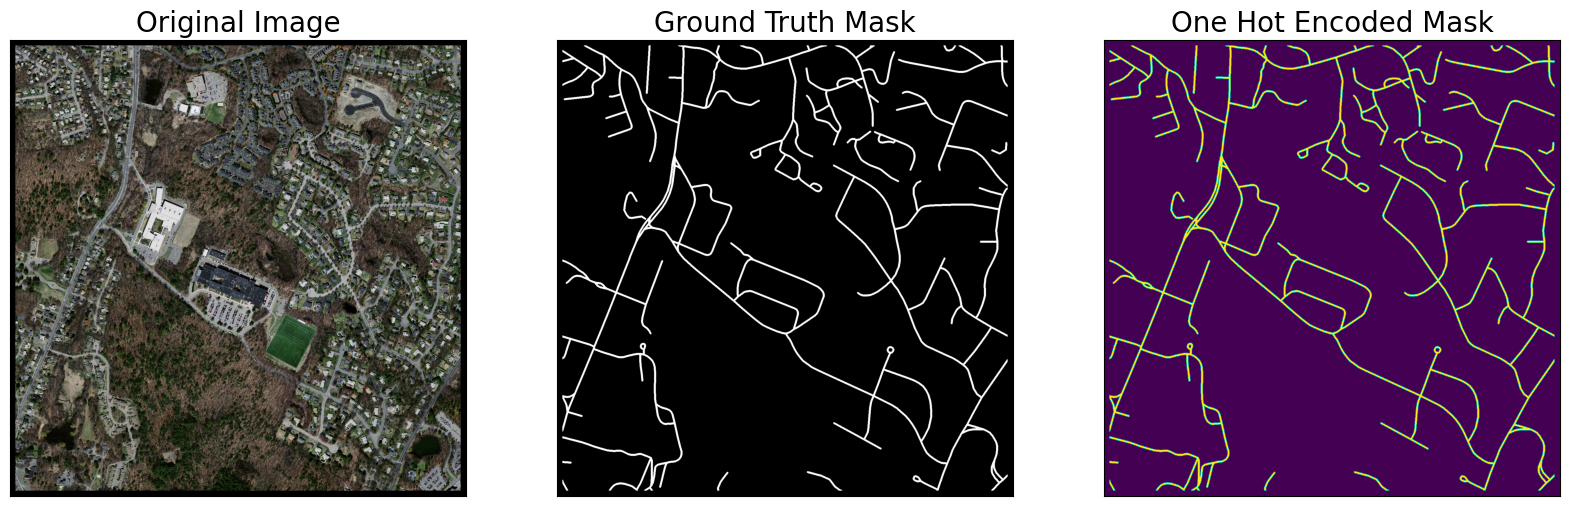

In [15]:
# create test dataloader to be used with UNet model (with preprocessing operation: to_tensor(...))
test_dataset = RoadsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = RoadsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [16]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    if padding<0:
        return image

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [17]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

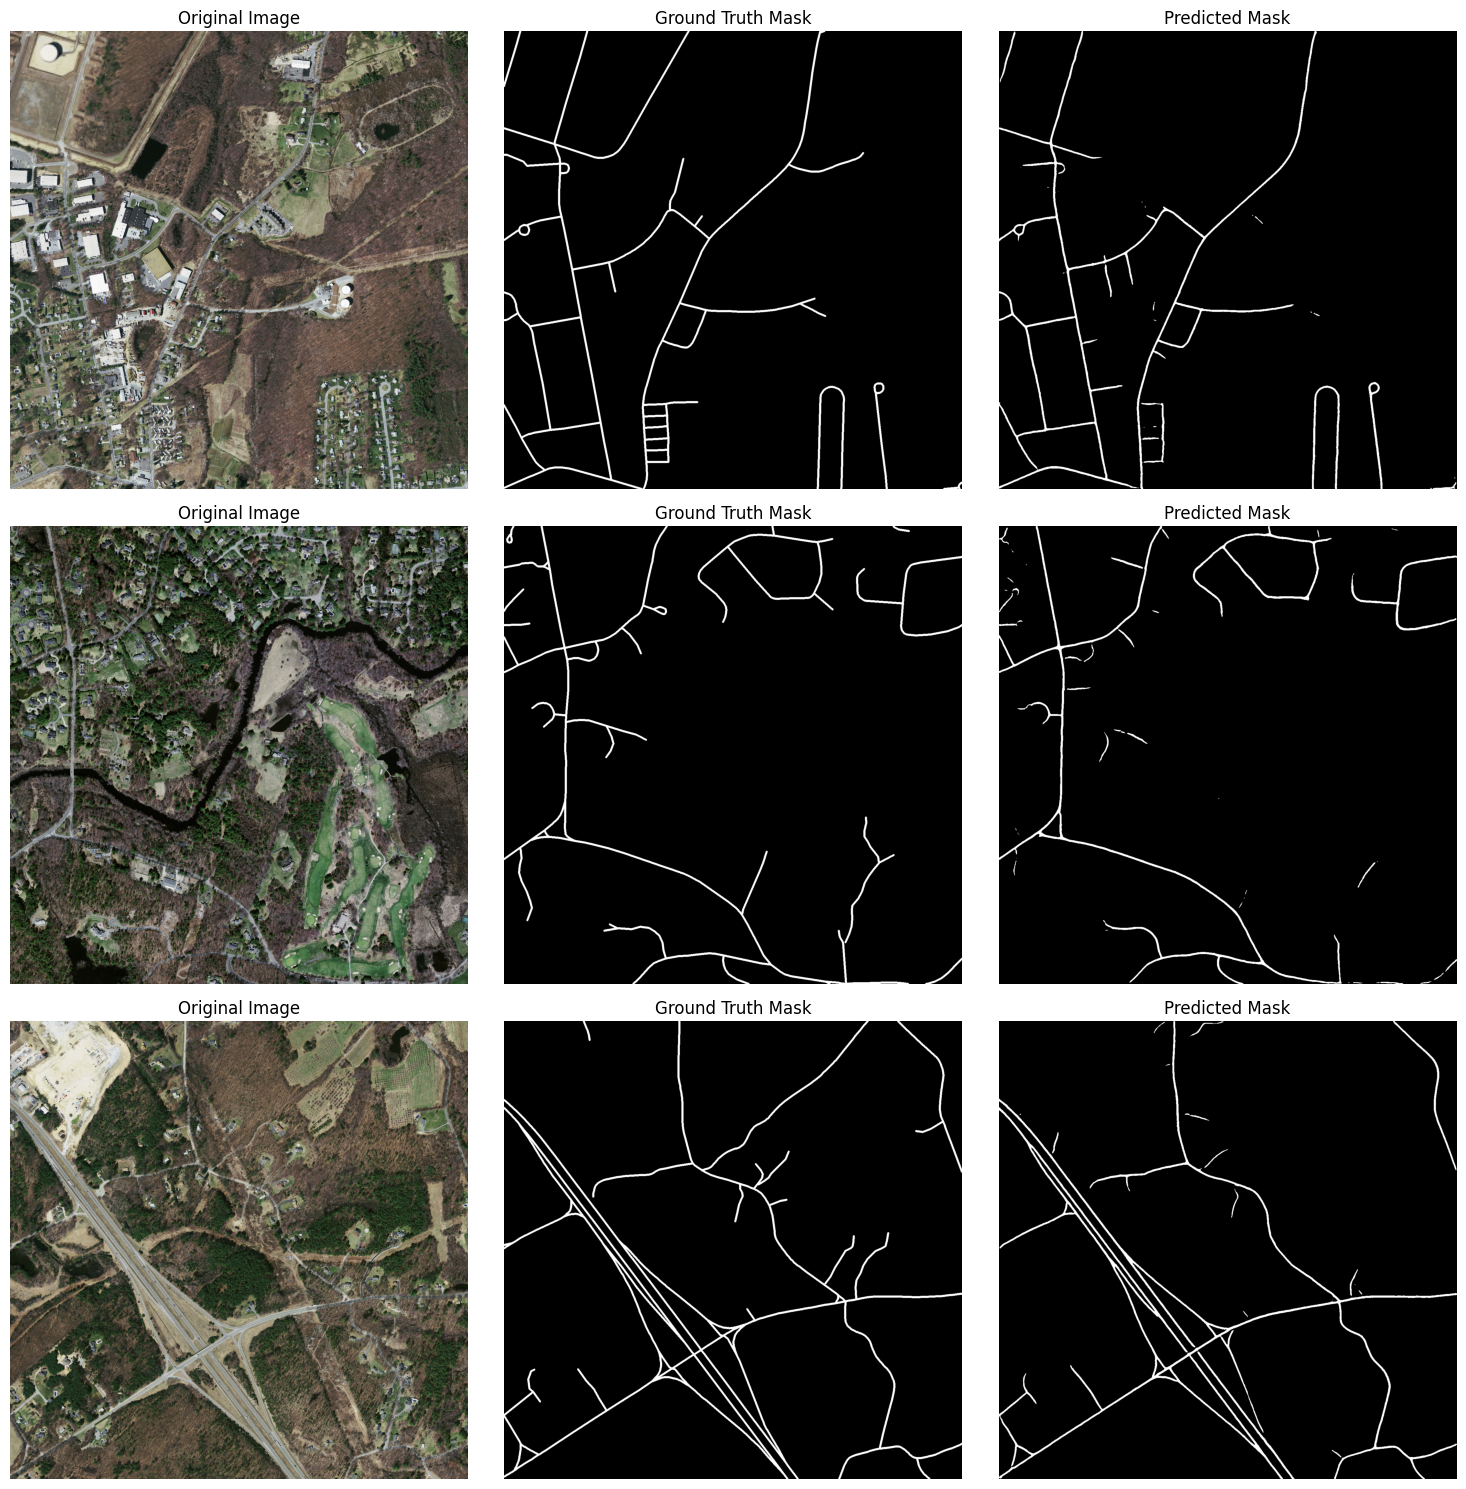

In [18]:
def visualize_predictions(dataset_vis, dataset_preprocessed, model, num_images=3):
    model.eval()
    indices = random.sample(range(len(dataset_vis)), num_images)
    
    plt.figure(figsize=(15, 5 * num_images))
    
    for i, idx in enumerate(indices):
        image_vis = dataset_vis[idx][0].astype('uint8')
        gt_mask = dataset_vis[idx][1] # This is one-hot encoded (H, W, C)
        
        image_vis_cropped = crop_image(image_vis)
        gt_mask_color = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))

        x_tensor, _ = dataset_preprocessed[idx] # We only need the image tensor
        x_tensor = torch.from_numpy(x_tensor).to(DEVICE).unsqueeze(0)
        
        with torch.no_grad():
            pr_mask = model(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy() # This will be (C, H, W)
        
        pr_mask_hwc = np.transpose(pr_mask, (1, 2, 0))
        pr_mask_color = crop_image(colour_code_segmentation(reverse_one_hot(pr_mask_hwc), select_class_rgb_values))
        
        plt.subplot(num_images, 3, i * 3 + 1)
        plt.imshow(image_vis_cropped)
        plt.title("Original Image")
        plt.axis("off")
        
        plt.subplot(num_images, 3, i * 3 + 2)
        plt.imshow(gt_mask_color)
        plt.title("Ground Truth Mask")
        plt.axis("off")
        
        plt.subplot(num_images, 3, i * 3 + 3)
        plt.imshow(pr_mask_color)
        plt.title("Predicted Mask")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_dataset_vis, test_dataset, model, num_images=3)

100%|██████████| 49/49 [00:32<00:00,  1.49it/s]


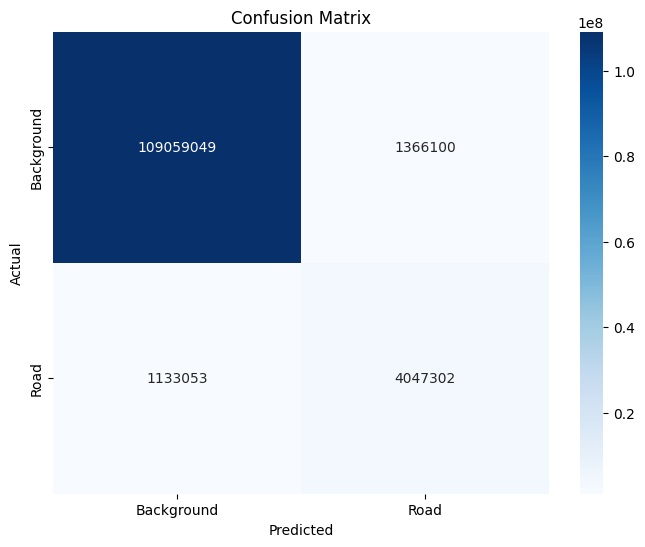


Confusion Matrix Results:
True Negatives (Background correct): 109059049
False Positives (Background as Road): 1366100
False Negatives (Road as Background): 1133053
True Positives (Road correct): 4047302


In [19]:
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

def generate_confusion_matrix(model, dataloader):
    model.eval()
    all_gt = []
    all_pr = []
    
    with torch.no_grad():
        for images, gt_masks in tqdm(dataloader):
            images = images.to(DEVICE)
            pr_masks = model(images)
            
            # Get binary predictions for road class
            gt_road = gt_masks[:, 1, :, :].flatten().cpu().numpy()
            pr_road = pr_masks[:, 1, :, :].flatten().cpu().numpy() > 0.5
            
            all_gt.extend(gt_road)
            all_pr.extend(pr_road)
    
    cm = confusion_matrix(all_gt, all_pr)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Background', 'Road'],
                yticklabels=['Background', 'Road'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    print("\nConfusion Matrix Results:")
    print(f"True Negatives (Background correct): {cm[0,0]}")
    print(f"False Positives (Background as Road): {cm[0,1]}")
    print(f"False Negatives (Road as Background): {cm[1,0]}")
    print(f"True Positives (Road correct): {cm[1,1]}")

# Generate and display confusion matrix
generate_confusion_matrix(model, test_loader)

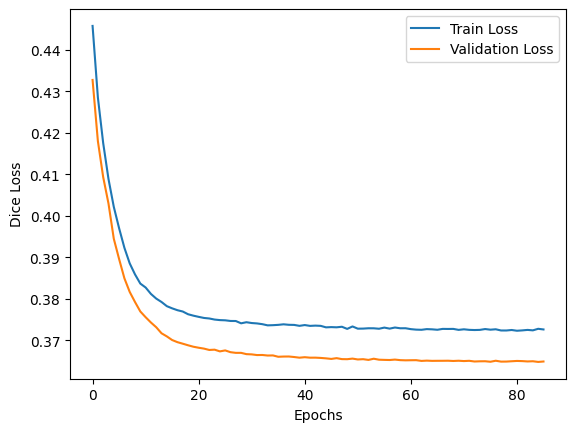

In [20]:
train_losses = [log['dice_loss'] for log in train_logs]
val_losses = [log['dice_loss'] for log in valid_logs]

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Dice Loss')
plt.legend()
plt.show()